## Lunar lander with DQN-style neural function approximator using PyTorch
### Christian Igel, 2025

If you have suggestions for improvement, [let me know](mailto:igel@diku.dk).

I took inspiration from https://github.com/udacity/deep-learning/blob/master/reinforcement/Q-learning-cart.ipynb.

Imports:

In [11]:
import gymnasium as gym

from tqdm.notebook import tqdm  # Progress bar

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Create the game environment (you need the `gym` package):

In [12]:
env_visual = gym.make('LunarLander-v3', render_mode="human")
action_size = 4
state_size = 8

Let's just test the environment first:

In [13]:
test_episodes = 0
for _ in range(test_episodes):
    R = 0
    state, _ = env_visual.reset()  # Environment starts in a random state, cart and pole are moving
    print("initial state:", state)
    while True:  # Environment sets "truncated" to true after 500 steps 
        env_visual.render()
        state, reward, terminated, truncated, _ = env_visual.step(env_visual.action_space.sample()) #  Take a random action
        R += reward  # Accumulate reward
        if terminated or truncated:
            print("return: ", R)
            env_visual.reset()
            break

In [14]:
#env.close()  # Closes the visualization window

Define *Q* network architecture:

In [15]:
class QNetwork(nn.Module):
    def __init__(self, state_size=8, action_size=4, hidden_size=10, bias=True):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size, bias)  
        self.fc2 = nn.Linear(hidden_size, hidden_size, bias)  
        self.output_layer = nn.Linear(hidden_size + state_size, action_size, bias)

    def forward(self, x_input):
        x = F.tanh(self.fc1(x_input))
        x = F.tanh(self.fc2(x))
        x = torch.cat((x_input, x), dim=1)
        x = self.output_layer(x)
        return x

Data structure for storing experiences:

In [16]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

Define basic constants:

In [17]:
train_episodes = 400           # Max number of episodes to learn from
gamma = 0.99                   # Future reward discount
learning_rate = 0.001          # Q-network learning rate
tau = .01                      # learning rate for target network

# Exploration parameters
explore_start = 1.0            # Exploration probability at start
explore_stop = 0.0001          # Minimum exploration probability 
decay_rate = 0.05              # Exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # Number of units in each Q-network hidden layer

# Memory parameters
memory_size = 10000            # Memory capacity
batch_size = 128               # Experience mini-batch size
pretrain_length = batch_size   # Number experiences to pretrain the memory

log_path = "/tmp/deep_Q_network"

Instantiate network:

In [18]:
mainQN = QNetwork(hidden_size=hidden_size)
print(mainQN)

QNetwork(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (output_layer): Linear(in_features=72, out_features=4, bias=True)
)


Initialize the experience memory: 

In [19]:
# Initialize the simulation
env = gym.make('LunarLander-v3')
state = env.reset()[0]

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in tqdm(range(pretrain_length)):
    # Make a random action
    action = env.action_space.sample()
    next_state, reward, terminated, truncated, _ = env.step(action)

    if terminated or truncated:
        # The simulation fails, so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, terminated, truncated, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

  0%|          | 0/128 [00:00<?, ?it/s]

Now train with experiences:

In [ ]:
total_reward_list = []  # Returns for the individual episodes

optimizer = torch.optim.AdamW(mainQN.parameters(), lr=learning_rate) # AdamW uses weight decay by default
loss_fn = torch.nn.MSELoss()

for ep in range(train_episodes):
    total_reward = 0  # Return / accumulated rewards
    state = env.reset()[0]  # Reset and get initial state
    while True:
        # Explore or exploit
        explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*ep) 
        if explore_p > np.random.rand():
            # Pick a random action
            action = env.action_space.sample()
        else:
            # Get action from Q-network
            state_tensor = torch.from_numpy(np.resize(state, (1, state_size)).astype(np.float32))
            Qs = mainQN(state_tensor)
            action = torch.argmax(Qs).item()

        # Take action, get new state and reward
        next_state, reward, terminated, truncated, _ = env.step(action)
    
        total_reward += reward  # Return / accumulated rewards
           
        if terminated or truncated:
            # Episode ends because of failure, so no next state
            next_state = np.zeros(state.shape)
                
            print('Episode: {}'.format(ep), 'Total reward: {}'.format(total_reward),
                  'Training loss: {:.4f}'.format(loss), 'Explore P: {:.4f}'.format(explore_p))
            total_reward_list.append((ep, total_reward))
                
            # Add experience to memory
            memory.add((state, action, reward, next_state))
            break; # End of episode
        else:
            # Add experience to memory
            memory.add((state, action, reward, next_state))
            state = next_state
            
        # Sample mini-batch from memory
        batch = memory.sample(batch_size)
        next_states_np = np.array([each[3] for each in batch], dtype=np.float32)
        next_states = torch.as_tensor(next_states_np)  # as_tensor does not copy the data
        rewards     = torch.as_tensor(np.array([each[2] for each in batch], dtype=np.float32)) 
        states      = torch.as_tensor(np.array([each[0] for each in batch], dtype=np.float32)) 
        actions     = torch.as_tensor(np.array([each[1] for each in batch]))
              
        # Compute Q values for all actions in the new state       
        target_Qs = mainQN(next_states)
            
        # Set target_Qs to 0 for states where episode ended because of failure
        episode_ends = (next_states_np == np.zeros(states[0].shape)).all(axis=1)
        target_Qs[episode_ends] = torch.zeros(action_size)
        
        # Compute targets
        y = rewards + gamma * torch.max(target_Qs, dim=1)[0]
        
        # Network learning starts here
        optimizer.zero_grad()
        
        # Compute the Q values of the actions taken        
        main_Qs = mainQN(states)  # Q values for all action in each state
        Q = torch.gather(main_Qs, 1, actions.unsqueeze(-1)).squeeze()  # Only the Q values for the actions taken
        
        # Gradient-based update
        loss = loss_fn(Q, y)
        loss.backward()
        optimizer.step()

Episode: 0 Total reward: -559.7829971798842 Training loss: 106.8023 Explore P: 1.0000
Episode: 1 Total reward: -99.33546712531913 Training loss: 78.5108 Explore P: 0.9512
Episode: 2 Total reward: -204.6930266105214 Training loss: 69.6299 Explore P: 0.9048
Episode: 3 Total reward: -108.48218108784705 Training loss: 63.0132 Explore P: 0.8607
Episode: 4 Total reward: -324.3533250635709 Training loss: 64.0282 Explore P: 0.8187
Episode: 5 Total reward: -559.9645876455016 Training loss: 94.2515 Explore P: 0.7788
Episode: 6 Total reward: -106.77740146620448 Training loss: 94.7611 Explore P: 0.7408
Episode: 7 Total reward: -261.39772037540484 Training loss: 112.8708 Explore P: 0.7047
Episode: 8 Total reward: -347.49522358484535 Training loss: 41.7291 Explore P: 0.6704
Episode: 9 Total reward: -285.70412693984656 Training loss: 12.6721 Explore P: 0.6377
Episode: 10 Total reward: -114.31392870669549 Training loss: 9.0740 Explore P: 0.6066
Episode: 11 Total reward: -102.38709929418702 Training lo

Save policy network:

In [21]:
torch.save(mainQN, log_path)

Plot learning process: 

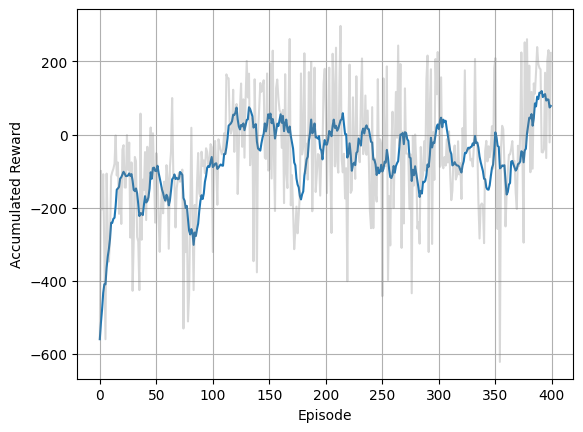

In [22]:
# Moving average for smoothing plot
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, x[0]*np.ones(N)))
    return (cumsum[N:] - cumsum[:-N]) / N

eps, rews = np.array(total_reward_list).T
smoothed_rews = running_mean(rews, 10)

plt.plot(eps, smoothed_rews)
plt.grid()
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Accumulated Reward')
plt.savefig('deepQ.pdf')

Evaluate stored policy:

In [24]:
testQN = torch.load(log_path, weights_only=False)

test_episodes = 5

for ep in range(test_episodes):
    state = env_visual.reset()[0]
    print("initial state:", state)
    R = 0
    while True:
        # Get action from Q-network
        # Hm, the following line could perhaps be more elegant ...
        state_tensor = torch.from_numpy(np.resize(state, (1, state_size)).astype(np.float32))
        Qs = testQN(state_tensor)
        action = torch.argmax(Qs).item()
            
        # Take action, get new state and reward
        next_state, reward, terminated, truncated, _ = env_visual.step(action)
        R += reward
            
        if terminated or truncated:
            print("reward:", R)
            break
        else:
            state = next_state
                

initial state: [-0.00440588  1.4005885  -0.44628358 -0.4591993   0.00511209  0.10108991
  0.          0.        ]
reward: -91.60248970786908
initial state: [-0.00184364  1.4023284  -0.18676016 -0.38185424  0.00214314  0.04230393
  0.          0.        ]
reward: 167.7933796663023
initial state: [ 0.00753975  1.4057759   0.7636797  -0.22865202 -0.00872988 -0.17298469
  0.          0.        ]
reward: -69.86382228334745
initial state: [-1.2939454e-03  1.4152757e+00 -1.3108464e-01  1.9357571e-01
  1.5062020e-03  2.9692624e-02  0.0000000e+00  0.0000000e+00]
reward: -135.56393246090346
initial state: [-0.00525208  1.4172866  -0.5319941   0.28294268  0.00609263  0.12050464
  0.          0.        ]
reward: -117.79084675757449
